<a href="https://colab.research.google.com/github/skumarudel/DS_Physicists/blob/master/Lecture3-Statistics/HypothesisTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
from sklearn.utils import resample

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Hypothesis Testing
Hypothesis testing uses concepts from statistics to determine the probability that a given assumption is valid. Typically hypothesis testing starts with an assumption or an assertion about a population parameter. For example, you may be interested in validating the claim of Philips that the average life of there bulb 10 years.

**The procedure to perform hypothesis testing is shown below**
- State the null hypothesis, and the statistics with which to test the statement
- Measured the observed statistics (from the observed data). For example mean, median or something else
- Randomly sample n data with replacement (or without replacement) from the observed data. This means the same point may appear upto n times in one sample
- Repeate the experiment thousands of time and store the statistics in an array
- Figure out the fraction of time the simulated dataset give statistics equal to or greater than the measured statistics.

# P-value
in statistical hypothesis testing, the p-value or probability value or asymptotic significance is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be greater than or equal to the actual observed results.

- So if the P-value is the probability of obtaining your sample data if H0 is true, it makes sense that past a certain point, we have to concede that our null hypothesis is false.
- In general, if p_value is less than 0.05 reject the null hypothesis otherwise retain it

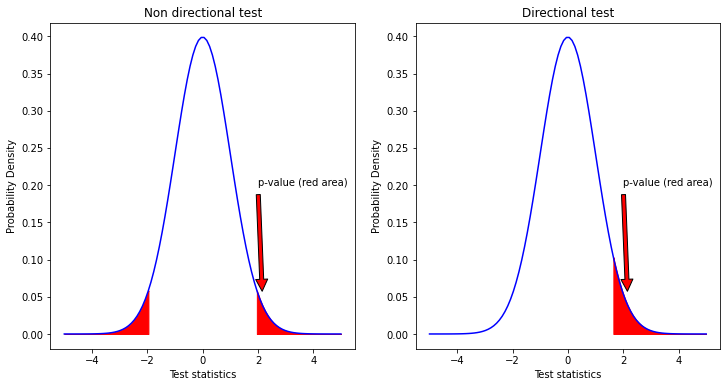

In [60]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
Null = 0
STD = 1
dist = stats.norm(Null,STD)
px_r= np.arange(dist.ppf(1 - (alpha/2)),5,0.01) # right
px_l = np.arange(-5,dist.ppf(alpha/2),0.01) # left
xy = np.linspace(-5+Null, Null+5,100)
axes[0].plot(xy, dist.pdf(xy), color='blue')
axes[0].fill_between(px_r,dist.pdf(px_r),color='r')
axes[0].fill_between(px_l,dist.pdf(px_l),color='r')
axes[0].set_ylabel('Probability Density')
axes[0].set_xlabel('Test statistics')
axes[0].set_title('Non directional test')

axes[0].annotate('p-value (red area)', xy=(dist.ppf(1 - (alpha/2))+0.2, 0.05), xytext=(2, 0.2),
            arrowprops=dict(facecolor='red', shrink=0.05));



axes[1].plot(xy, dist.pdf(xy), color='blue')
axes[1].fill_between(np.arange(dist.ppf(1 - alpha),5,0.01),dist.pdf(np.arange(dist.ppf(1 - alpha),5,0.01)),color='r')
axes[1].set_ylabel('Probability Density')
axes[1].set_xlabel('Test statistics')
axes[1].set_title('Directional test')

axes[1].annotate('p-value (red area)', xy=(dist.ppf(1 - (alpha/2))+0.2, 0.05), xytext=(2, 0.2),
            arrowprops=dict(facecolor='red', shrink=0.05));


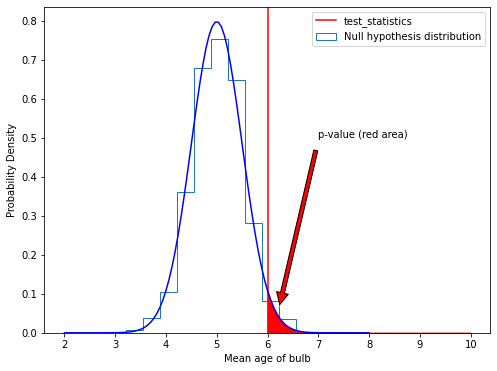

In [61]:
Null = 5. # Height
Alternate = 6.
std = 0.5
fig,axes = plt.subplots(figsize=(8,6))
x = np.random.normal(Null,std,1000)
axes.hist(x, density=True, label='Null hypothesis distribution', histtype='step')
plt.axvline(Alternate, color='red', label='test_statistics')
px=np.arange(Alternate,10,0.01)
dist=stats.norm(Null,std)
xy = np.linspace(-3+Null, Null+3,100)
axes.plot(xy, dist.pdf(xy), color='blue')
axes.fill_between(px,iq.pdf(px),color='r')
plt.ylabel('Probability Density')
plt.xlabel('Mean age of bulb')

axes.annotate('p-value (red area)', xy=(Alternate+0.2, 0.05), xytext=(7, 0.5),
            arrowprops=dict(facecolor='red', shrink=0.05))

plt.legend();


# Understanding the sales of a particular product using Web engagement as a proxy

In [118]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
from sklearn.utils import resample

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Files required for analysis

In [119]:
path_to_data = 'https://raw.githubusercontent.com/skumarudel/DS_Physicists/master/Lecture3-Statistics/datafiles/'

WEB_PAGE_DATA_CSV = path_to_data + 'web_page_data.csv'
FOUR_SESSIONS_CSV =  path_to_data + 'four_sessions.csv'

In [120]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 60 * session_times.Time  # convert to seconds


In [121]:
session_times.head()



,Page,Time
0,Page A,12.6
1,Page B,151.8
2,Page A,21.0
3,Page B,42.6
4,Page A,40.2


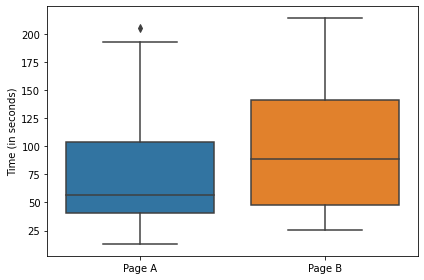

In [122]:
ax = sns.boxplot(x="Page", y="Time", data=session_times)
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [123]:
len(session_times[session_times.Page == 'Page B'])

15

In [124]:
df_time = session_times.groupby(['Page']).mean().reset_index().rename(columns={'Time': 'Mean_Time'})
df_time

,Page,Mean_Time
0,Page A,75.8
1,Page B,97.2


In [125]:
observed_diff = df_time.Mean_Time.iloc[1] - df_time.Mean_Time.iloc[0]
print("Average time difference spend by customers on PageB vs PageA = {:.1f} seconds".format(observed_diff))

Average time difference spend by customers on PageB vs PageA = 21.4 seconds


In [126]:
def difference_of_means(x,y):
    return np.mean(y) -  np.mean(x)

def test_null(df, iters = 1000):
  groupA = len(df[df.Page == "Page A"])
  groupA = len(df[df.Page == "Page B"])
  time = df.Time.to_numpy()
  means_diff = np.zeros(iters)
  for i in range(iters):
      resample_data = resample(time, replace=False)
      xx, yy = resample_data[:groupA], resample_data[groupA:]
      means_diff[i] = difference_of_means(xx,yy)
        
        
  return means_diff
    

The p-value for these samples is 0.14
We can not reject the null hypothesis i.e Page B is not statistically different from Page A


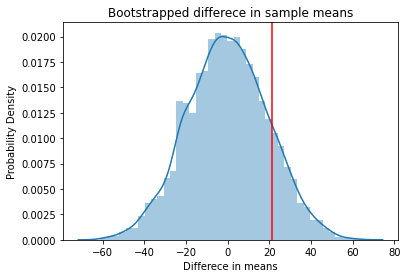

In [127]:
np.random.seed(5)
diff_of_mean = test_null(session_times, iters=5000)
sns.distplot(diff_of_mean)
    
plt.title('Bootstrapped differece in sample means')
plt.xlabel('Differece in means')
plt.ylabel('Probability Density')
plt.axvline(observed_diff, color='red')
#plt.legend()
p_value = np.sum(diff_of_mean >= observed_diff) / len(diff_of_mean)
print("The p-value for these samples is {:.2g}".format(p_value))

if p_value < 0.05:
    print('We can reject the null hypothesis that Page B is better than Page A in terms of retenion of customers')
else:
    print('We can not reject the null hypothesis i.e Page B is not statistically different from Page A')



In [128]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


## ANOVA

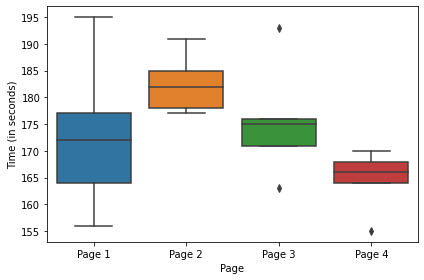

In [90]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = sns.boxplot(x='Page', y='Time',data=four_sessions)
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [91]:
four_sessions.head(10)

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [97]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))




Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
23.746666666666666


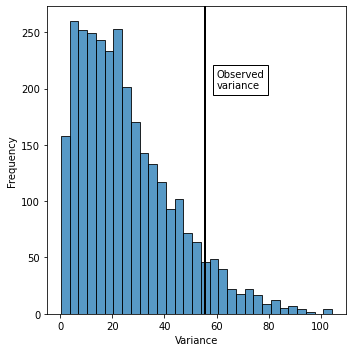

In [117]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

p_value_var = np.sum(perm_variance >= observed_variance) / len(perm_variance)
#print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(perm_variance)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [107]:
p_value_var

0.08366666666666667

In [114]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)


            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [115]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388


## OLS regression using stats model

In [25]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()


,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


In [32]:
len(df)

85

In [38]:
mod = smf.ols(formula='Lottery ~ Wealth', data=df)
res = mod.fit()

In [39]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     26.67
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.63e-06
Time:                        00:01:06   Log-Likelihood:                -380.99
No. Observations:                  85   AIC:                             766.0
Df Residuals:                      83   BIC:                             770.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.8602      4.725      4.626      0.0

# T statistics is defined as

$t_{stat} = \frac{(\hat{\beta} - \beta_{0})}{SE(\hat{\beta})} = (0.4859 - 0) / 0.094 = 5.169$